In [180]:
import docx
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx import Document
from docx.shared import Inches
from docx.shared import Pt
import time
import plotly
from time import gmtime, strftime
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import matplotlib.font_manager as fm
import matplotlib
font_location = 'C://Windows//Fonts//malgun.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [181]:
ismart = pd.read_csv('./data/ismart_new.csv')
ismart = ismart.iloc[:,1:]
ismart.columns = ['timestamp','usage','max_usage']

In [182]:
timestamp = ismart.timestamp
day = timestamp.str.slice(start=0,stop=10)
times = timestamp.str.slice(start=11,stop=20)
year = timestamp.str.slice(start=0,stop=4)
month = timestamp.str.slice(start=5,stop=7)
hour = timestamp.str.slice(11,13)
week = []
for time in timestamp:
    y = int(time[0:4])
    m = int(time[5:7])
    d = int(time[8:10])
    week.append(datetime.date(y,m,d).weekday())
week = np.array(week)
weekday = np.where(week==0,'월요일',
                   np.where(week==1,'화요일',
                           np.where(week==2,'수요일',
                                   np.where(week==3,'목요일',
                                           np.where(week==4,'금요일',
                                                   np.where(week==5,'토요일','일요일'))))))

ismart['day'] = day
ismart['time'] = times
ismart['year'] = year
ismart['month'] = month
ismart['week'] = week
ismart['weekday'] = weekday
ismart['hour'] = hour
year_range = ismart.year.unique().size
year_max = ismart.year.unique().max()
years = ismart.year.unique()

In [183]:
#현재년도 월별 에너지 사용량
curr_year = ismart.year.unique().max()
curr_monthly_usage = ismart[ismart.year==curr_year].groupby('month').usage.sum()

In [184]:
#년도별 에너지 총 사용량
total_usage = ismart.groupby('year').usage.sum()
#년도별 월별 에너지 총 사용량
total_monthly_usage = ismart.groupby(['year','month']).usage.sum()
year_monthly_usage = total_monthly_usage.reset_index().pivot(index='year',columns='month',values='usage').fillna(0)

rowsum = []
for i in year_monthly_usage.index:
    tmp = np.sum(year_monthly_usage[year_monthly_usage.index==i].values)
    rowsum.append(tmp)

year_monthly_usage['rowsum'] = rowsum

colsum = []
for i in year_monthly_usage.columns:
    tmp = np.sum(year_monthly_usage[i])
    colsum.append(tmp)

#년도별 월별 peak 에너지 총 사용량
total_monthly_maxdemand = ismart.groupby(['year','month']).max_usage.sum()
year_monthly_maxdemand = total_monthly_maxdemand.reset_index().pivot(index='year',columns='month',values='max_usage').fillna(0)

rowsum = []
for i in year_monthly_maxdemand.index:
    tmp = np.sum(year_monthly_maxdemand[year_monthly_maxdemand.index==i].values)
    rowsum.append(tmp)

year_monthly_maxdemand['rowsum'] = rowsum


colsum_maxdemand = []
for i in year_monthly_maxdemand.columns:
    tmp = np.sum(year_monthly_maxdemand[i])
    colsum_maxdemand.append(tmp)

winter = ismart.query("month in ['11','12','01','02','03','04']")
summer = ismart.query("month in ['06','07','08','09']")
middle = ismart.query("month in ['05','10']")

ismart_weekday = ismart[ismart.year==curr_year].groupby(['weekday','time']).max_usage.mean()
ismart_week = ismart[ismart.year==curr_year].groupby(['weekday']).max_usage.mean()
ismart_month = ismart[ismart.year==curr_year].groupby(['month']).max_usage.mean()
ismart_hour = ismart[ismart.year==curr_year].groupby(['time']).max_usage.mean()

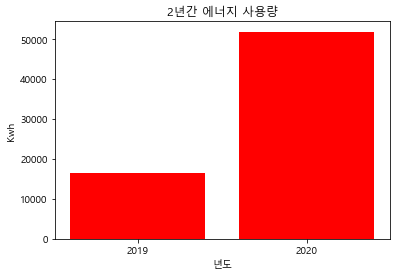

In [185]:
plt.figure(figsize=(6,4))
x = total_usage.values
y = (pd.Series(total_usage.index))
plt.xticks(range(len(x)), y)
plt.xlabel('년도')
plt.ylabel('Kwh')
plt.title(str(year_range)+'년간 에너지 사용량')
plt.bar(range(len(x)), x, color='red') 
plt.savefig('./images/total_year_usage.png',dpi=200, facecolor='#eeeeee', edgecolor='blue')

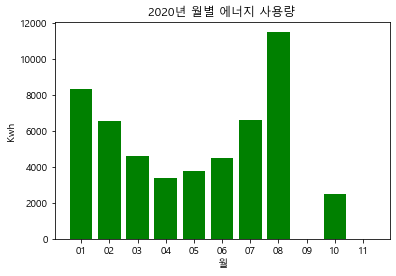

In [186]:
plt.figure(figsize=(6,4))
x = curr_monthly_usage.values
y = (pd.Series(curr_monthly_usage.index))
plt.xticks(range(len(x)), y)
plt.xlabel('월')
plt.ylabel('Kwh')
plt.title(str(curr_year)+'년 월별 에너지 사용량')
plt.bar(range(len(x)), x, color='green') 
plt.savefig('./images/year_hist_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')

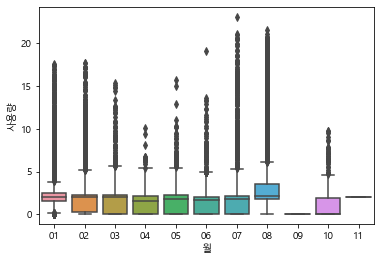

In [187]:
box_data = ismart.loc[ismart.year==curr_year,["month","usage"]]
box_data.columns = ['월','사용량']
sns.boxplot(x="월", y="사용량", data=box_data)
plt.savefig('./images/year_boxplot_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')

In [188]:
def make_elec(year,gubun):
    year = str(year)
    plt.figure(figsize=(6,4))
    df = ismart.loc[ismart.year==year,::].groupby(['month'])[gubun].sum()
    x = df.values
    y = (pd.Series(df.index))
    plt.xticks(range(len(x)), y)
    plt.xlabel('월')
    plt.ylabel('Mwh')
    plt.title(year+'년 월별 에너지 사용량')
    plt.bar(range(len(x)), x, color='green') 
    plt.savefig('./images/year_hist_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')

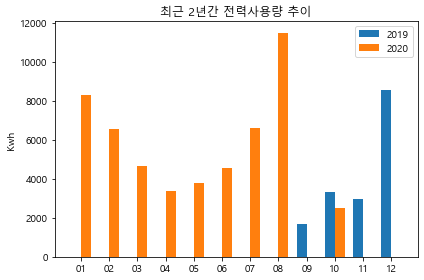

In [189]:

labels = ['01','02','03','04','05','06','07','08','09','10','11','12']
if year_monthly_usage.index.size == 3:
    name1 = year_monthly_usage.index[0]
    name2 = year_monthly_usage.index[1]
    name3 = year_monthly_usage.index[2]

    val1 = list(year_monthly_usage.iloc[0,0:12])
    val2 = list(year_monthly_usage.iloc[1,0:12])
    val3 = list(year_monthly_usage.iloc[2,0:12])

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val1, width, label=name1)
    rects2 = ax.bar(x + width/2, val2, width, label=name2)
    rects3 = ax.bar(x + width/2, val2, width, label=name3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Kwh')
    ax.set_title('최근 3년간 전력사용량 추이')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.savefig('./images/year_total_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
elif year_monthly_usage.index.size == 2:
    name1 = year_monthly_usage.index[0]
    name2 = year_monthly_usage.index[1]
    

    val1 = list(year_monthly_usage.iloc[0,0:12])
    val2 = list(year_monthly_usage.iloc[1,0:12])
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val1, width, label=name1)
    rects2 = ax.bar(x + width/2, val2, width, label=name2)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Kwh')
    ax.set_title('최근 2년간 전력사용량 추이')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.savefig('./images/year_total_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
else:
    name1 = year_monthly_usage.index[0]
    

    val1 = list(year_monthly_usage.iloc[0,0:12])
    
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val1, width, label=name1)
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Kwh')
    ax.set_title('최근 1년간 전력사용량 추이')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.savefig('./images/year_total_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')

In [195]:
winter_weekday = winter.groupby(['year','weekday','hour','week']).usage.sum().reset_index()
summer_weekday = summer.groupby(['year','weekday','hour','week']).usage.sum().reset_index()

def season_usage_graph(year):
    weekday = winter_weekday[winter_weekday.year==year]
    title = '{}년 요일별 동절기 에너지 사용 현황'.format(year)
    document.add_heading(title)
    for i in np.sort(weekday.week.unique()):
        x = weekday[weekday.week == i].hour
        y = weekday[weekday.week == i].usage
        week = weekday[weekday.week == i].weekday.unique()
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-',color='red')
        plt.title(year+'년 동절기 '+week+' 에너지 사용량')
        plt.savefig('./images/week_winter_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/week_winter_usage.png")
    
    weekday = summer_weekday[summer_weekday.year==year]
    title = '{}년 요일별 하절기 에너지 사용 현황'.format(year)
    document.add_heading(title)
    for i in np.sort(weekday.week.unique()):
        x = weekday[weekday.week == i].hour
        y = weekday[weekday.week == i].usage
        week = weekday[weekday.week == i].weekday.unique()
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-')
        plt.title(year+'년 하절기 '+week+' 에너지 사용량')
        plt.savefig('./images/week_summer_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/week_summer_usage.png")

winter_max_weekday = winter.groupby(['year','weekday','hour','week']).max_usage.sum().reset_index()
summer_max_weekday = summer.groupby(['year','weekday','hour','week']).max_usage.sum().reset_index()

def season_max_graph(year):
    weekday = winter_max_weekday[winter_max_weekday.year==year]
    title = '{}년 동절기 요일별 최대수요'.format(year)
    document.add_heading(title)
    for i in np.sort(weekday.week.unique()):
        x = weekday[weekday.week == i].hour
        y = weekday[weekday.week == i].max_usage
        week = weekday[weekday.week == i].weekday.unique()
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-',color='red')
        plt.title(year+'년 동절기 '+week+' 최대수요 사용량')
        plt.savefig('./images/week_winter_max_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/week_winter_max_usage.png")
    
    weekday = summer_max_weekday[summer_weekday.year==year]
    title = '{}년 하절기 요일별 최대수요'.format(year)
    document.add_heading(title)
    for i in np.sort(weekday.week.unique()):
        x = weekday[weekday.week == i].hour
        y = weekday[weekday.week == i].max_usage
        week = weekday[weekday.week == i].weekday.unique()
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-')
        plt.title(year+'년 하절기 '+week+' 최대수요 사용량')
        plt.savefig('./images/week_summer_max_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/week_summer_max_usage.png")


In [410]:
usage_day = ismart.groupby(['year','month','day']).usage.sum().reset_index()
usage_month = usage_day.groupby(['year','month']).usage.max().reset_index()
def day_usage_graph(year):
    title = '{}년 월별 최대수요일 (usage 기반)'.format(year)
    document.add_heading(title)
    month = usage_day[usage_day.year==year].month
    for i in month.unique():
        document.add_heading('{}년 {}월'.format(year,i))
        year = year
        stmt = "(year== '"+year+"') and (month=='"+i+"')"
        usage = usage_month.query(stmt).usage
        usage = usage.values[0]
        stmt = stmt + " and (usage == '"+str(usage)+"')"
        if usage > 0:
            day = usage_day.query(stmt).day[0:1].values
        df = ismart[ismart.day==day[0]].groupby('hour').usage.sum().reset_index()
        x = df.hour
        y = df.usage
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-')
        plt.title(year+'년 '+i+' 월 최대사용일('+ day + ')현황')
        plt.savefig('./images/daily_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/daily_usage.png")

In [411]:
max_usage_day = ismart.groupby(['year','month','day']).max_usage.mean().reset_index()
max_usage_month = max_usage_day.groupby(['year','month']).max_usage.mean().reset_index()
def day_max_usage_graph(year):
    title = '{}년 월별 최대수요일 (max_usage 기반)'.format(year)
    document.add_heading(title)
    month = max_usage_day[max_usage_day.year==year].month
    for i in month.unique():
        document.add_heading('{}년 {}월'.format(year,i))
        year = year
        stmt = "(year== '"+year+"') and (month=='"+i+"')"
        usage = usage_month.query(stmt).usage
        usage = usage.values[0]
        stmt = stmt + " and (usage == '"+str(usage)+"')"
        if usage > 0:
            day = usage_day.query(stmt).day[0:1].values
        df = ismart[ismart.day==day[0]].groupby('hour').usage.sum().reset_index()
        x = df.hour
        y = df.usage
        plt.figure(figsize=(7,4))
        plt.xlabel('시간')
        plt.ylabel('Mwh')
        plt.plot(x,y,'bo-')
        plt.title(year+'년 '+i+' 월 최대사용일('+ day + ')현황')
        plt.savefig('./images/max_daily_usage.png', dpi=200, facecolor='#eeeeee', edgecolor='blue')
        document.add_picture("./images/max_daily_usage.png")

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\anaconda3\lib

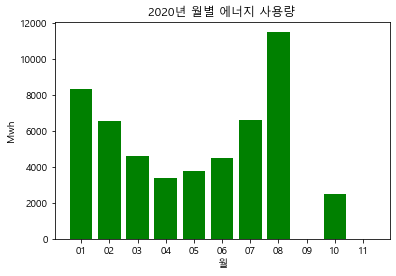

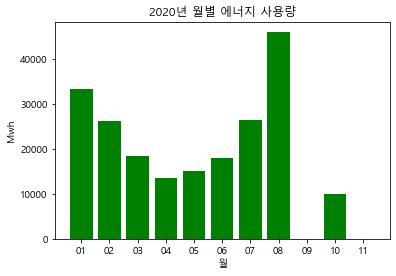

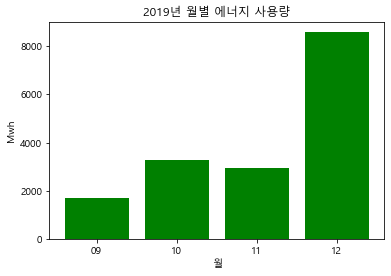

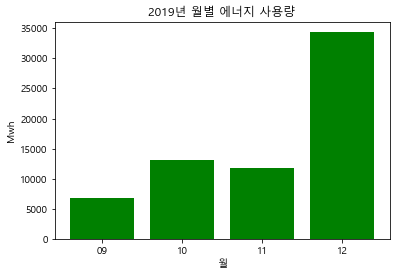

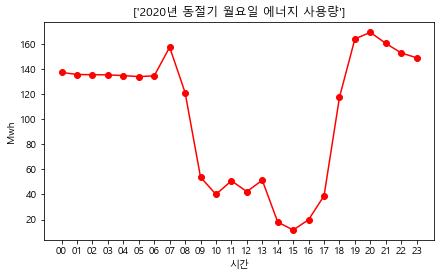

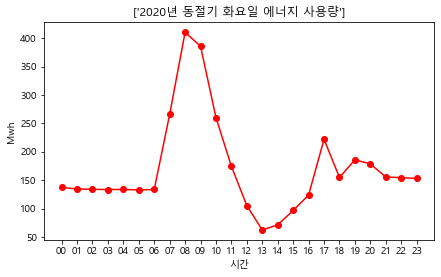

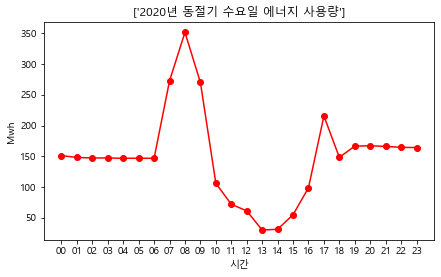

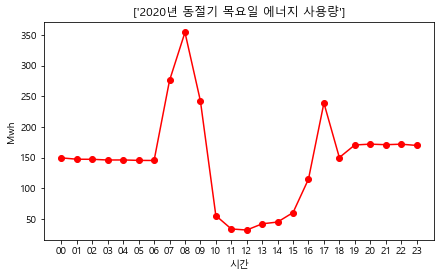

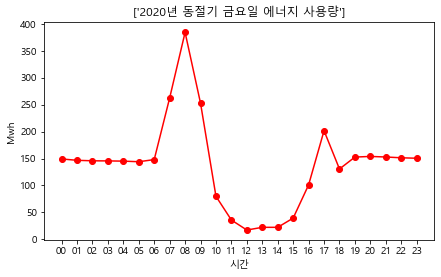

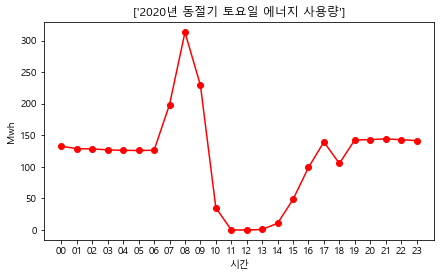

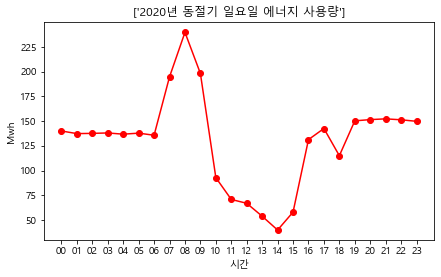

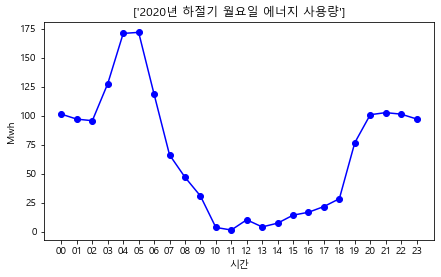

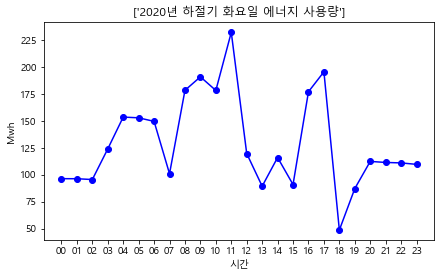

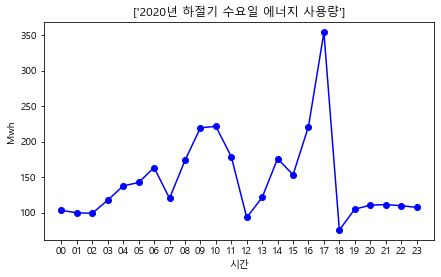

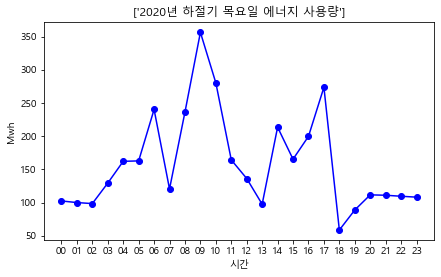

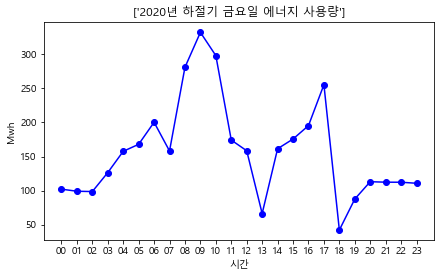

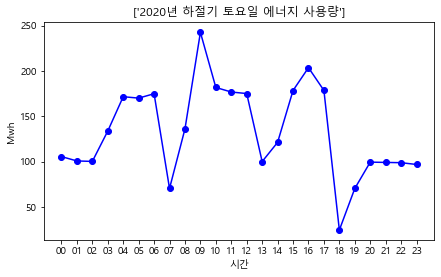

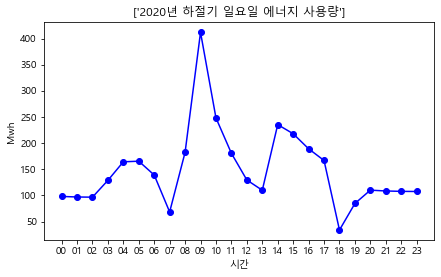

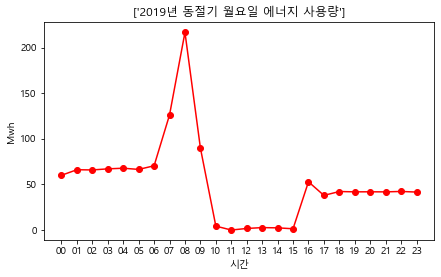

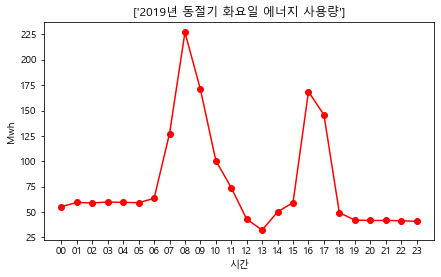

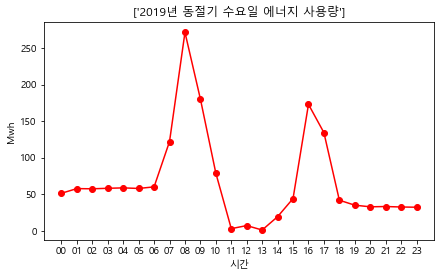

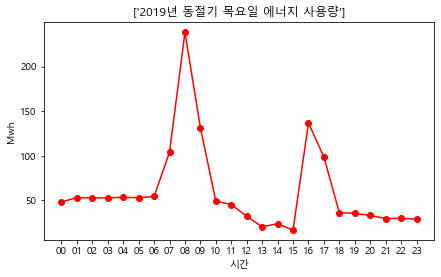

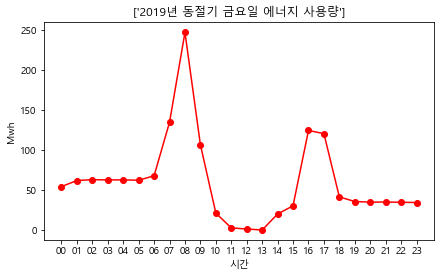

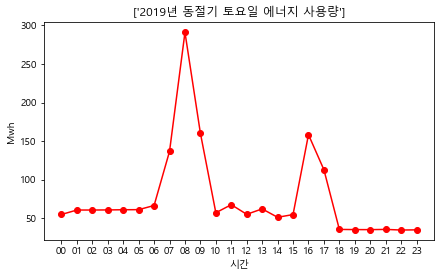

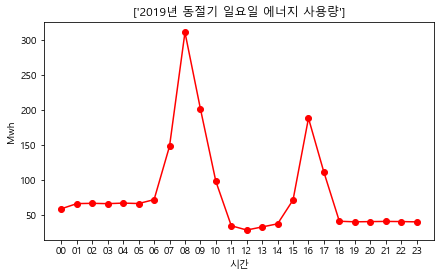

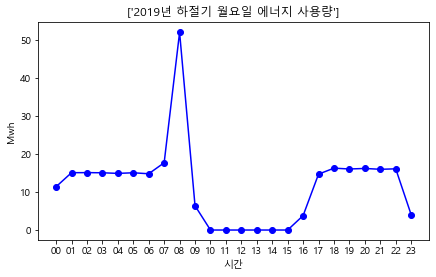

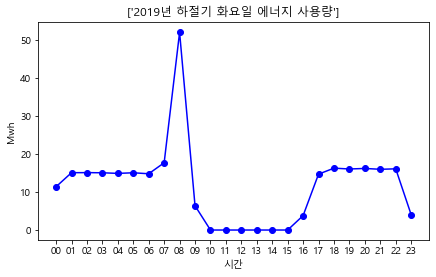

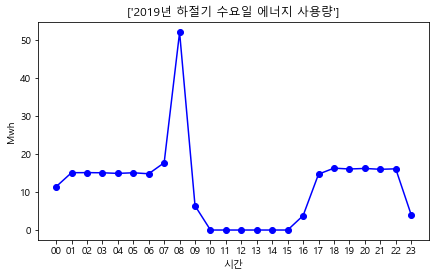

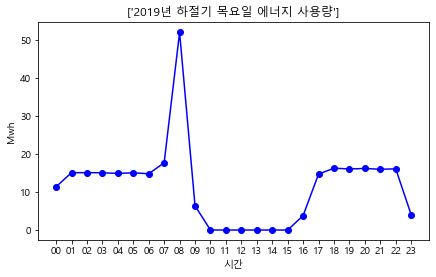

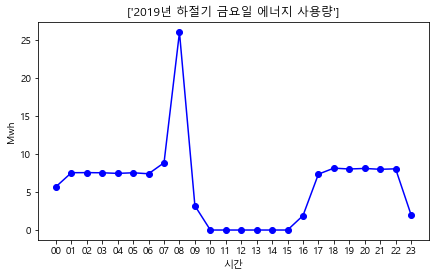

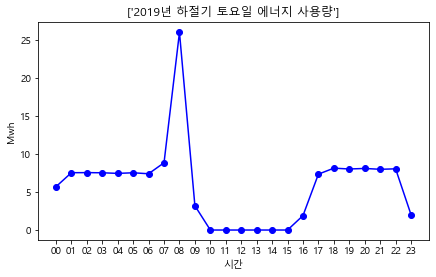

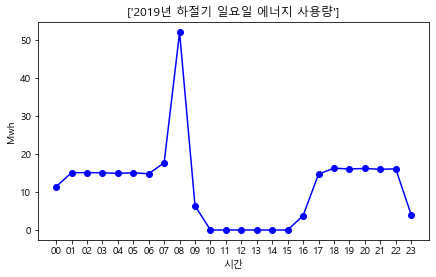

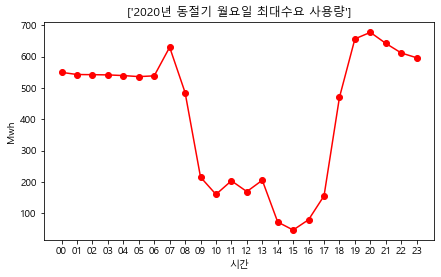

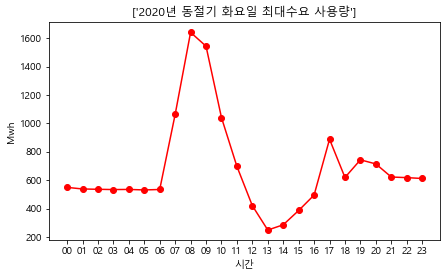

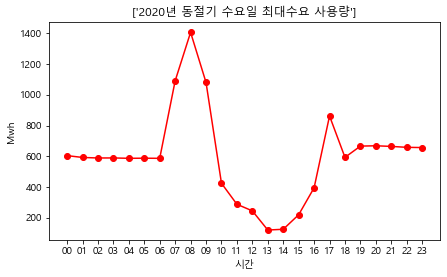

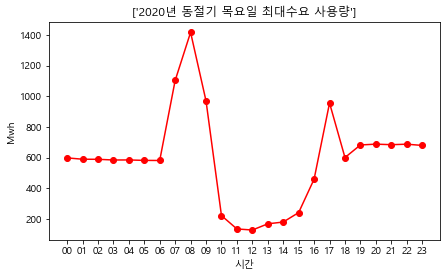

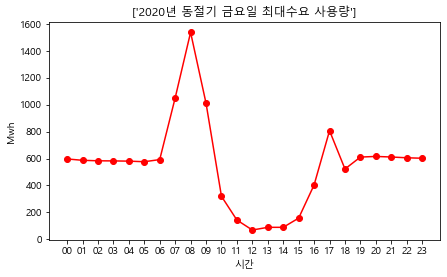

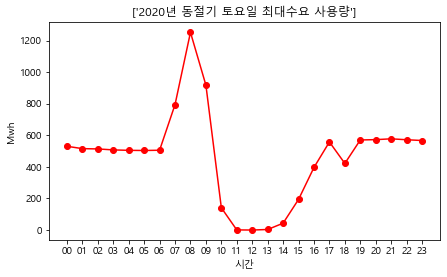

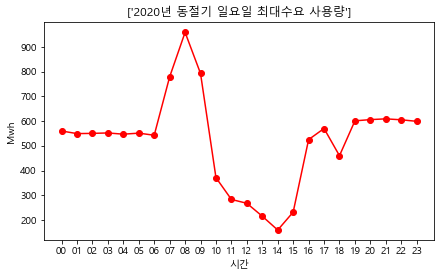

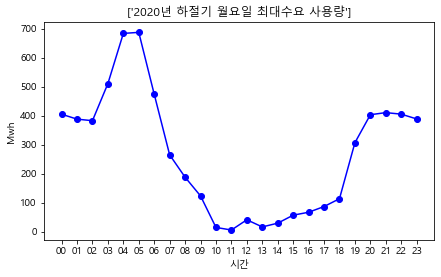

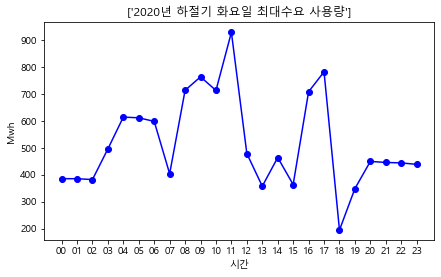

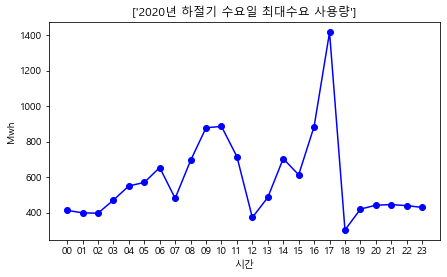

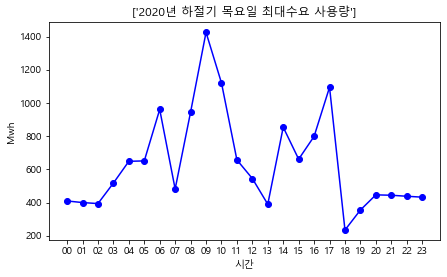

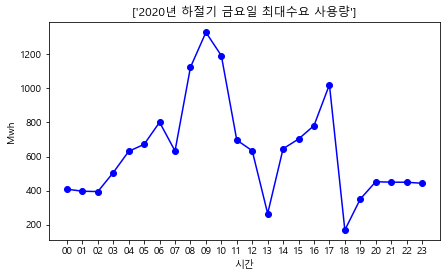

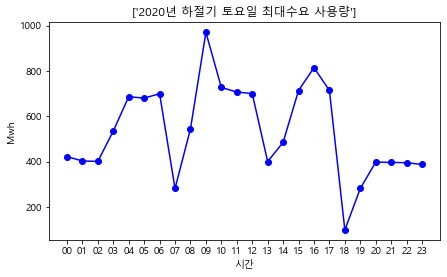

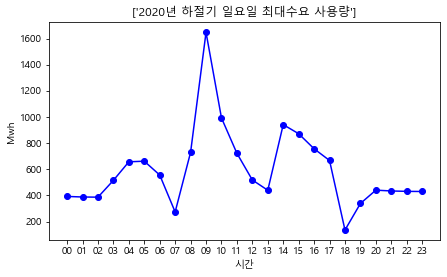

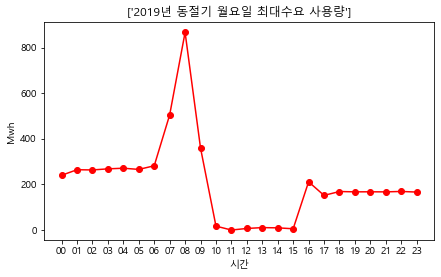

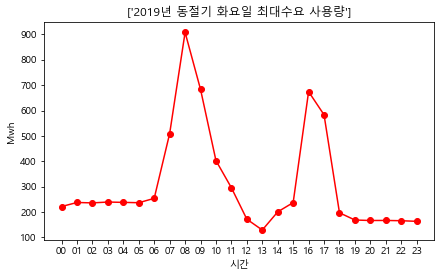

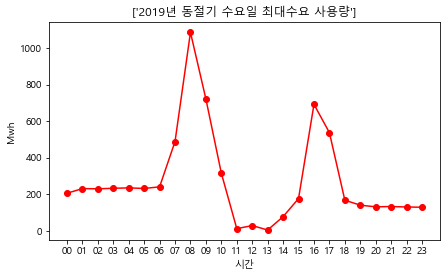

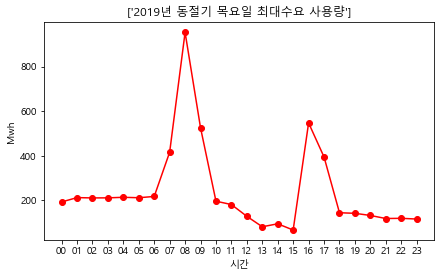

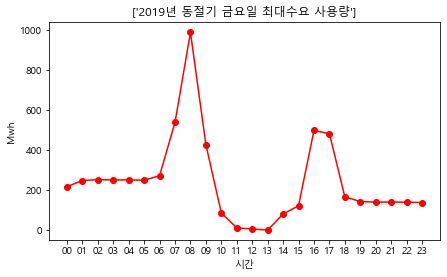

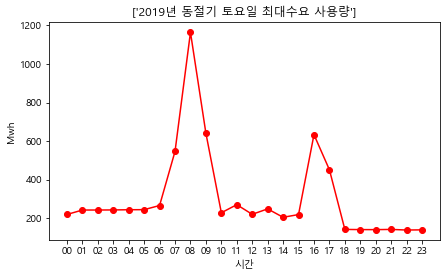

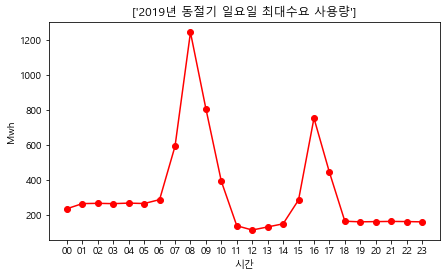

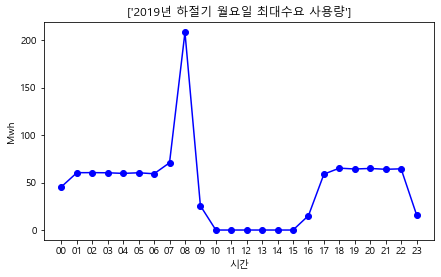

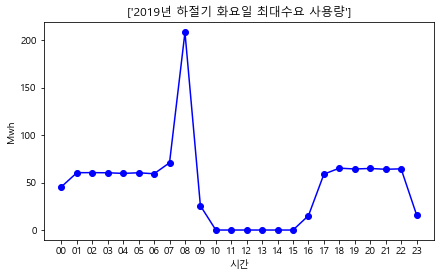

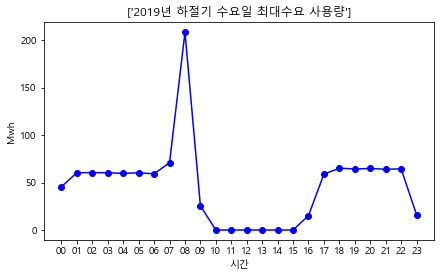

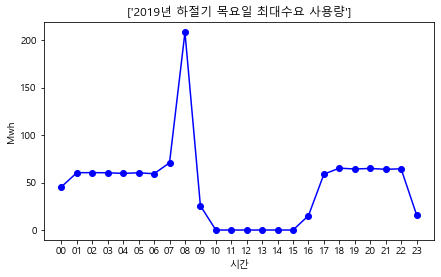

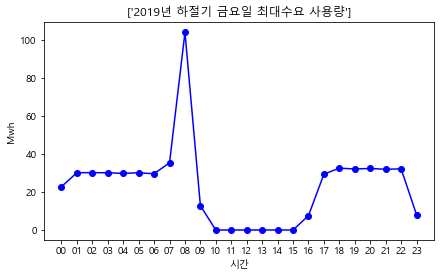

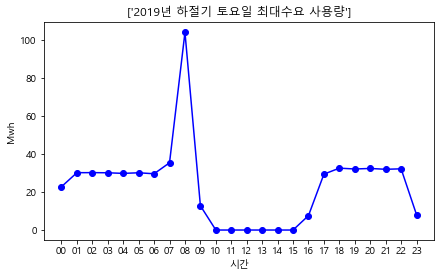

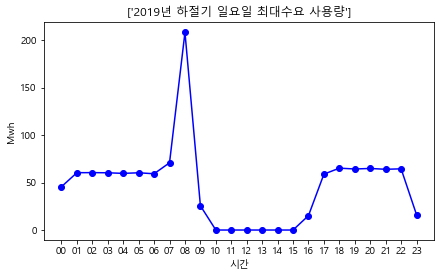

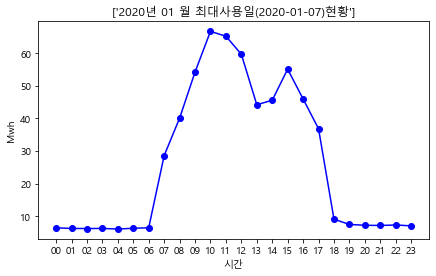

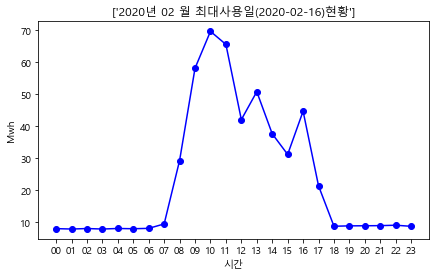

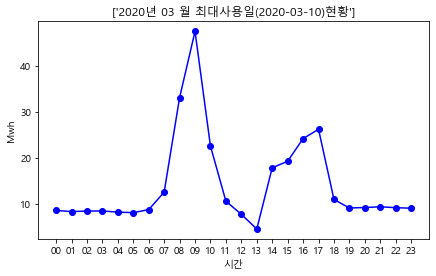

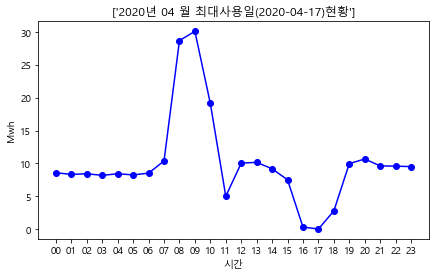

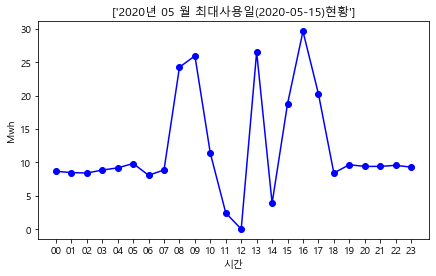

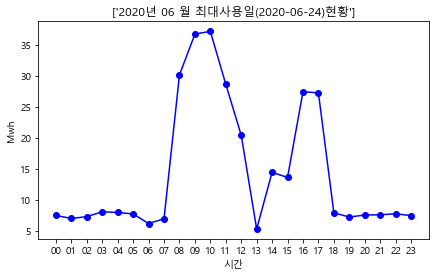

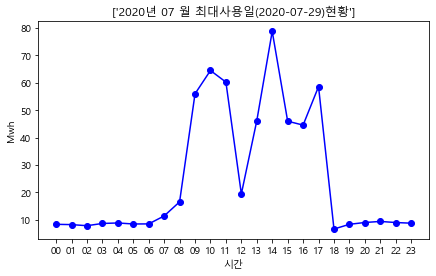

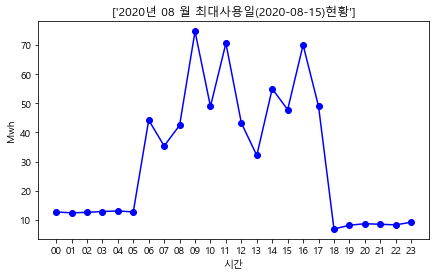

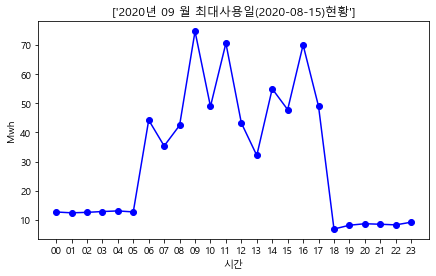

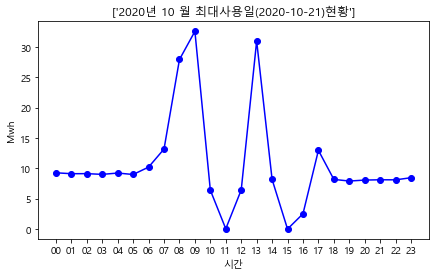

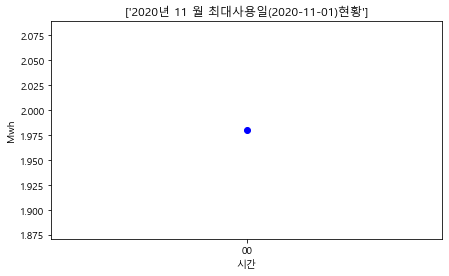

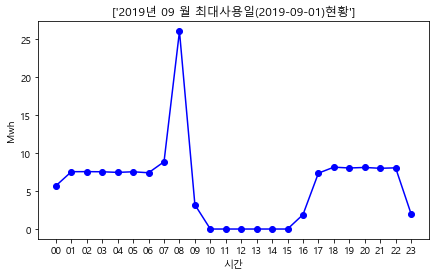

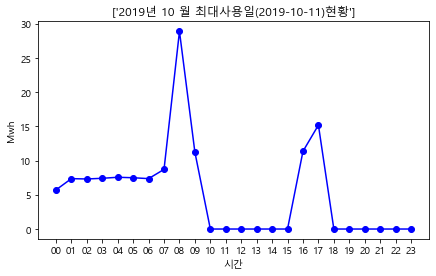

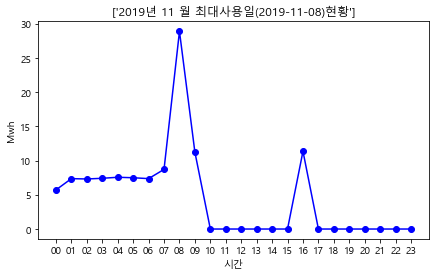

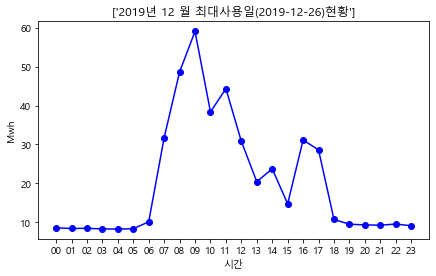

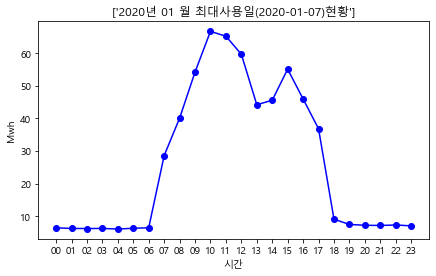

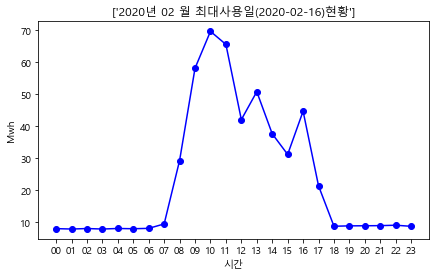

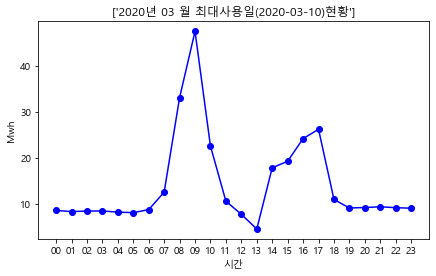

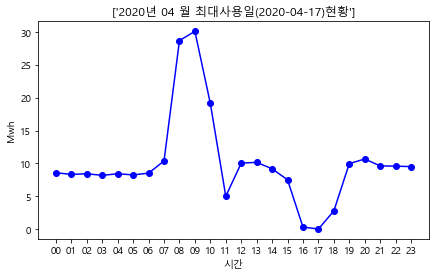

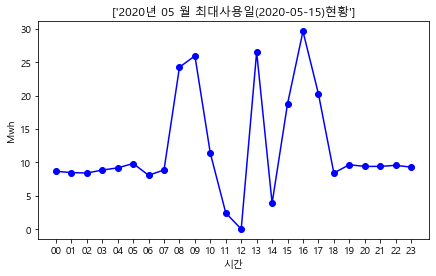

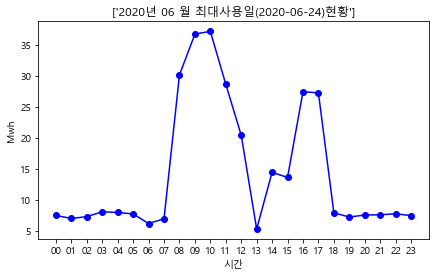

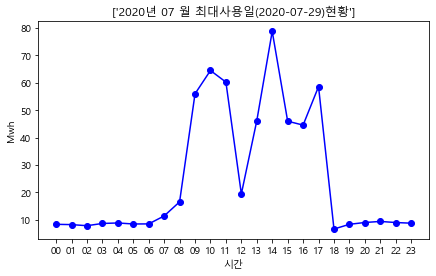

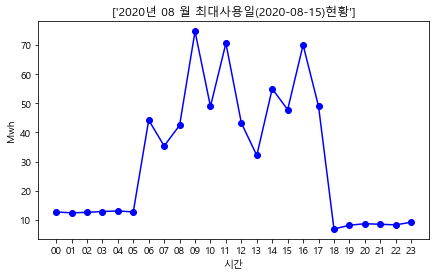

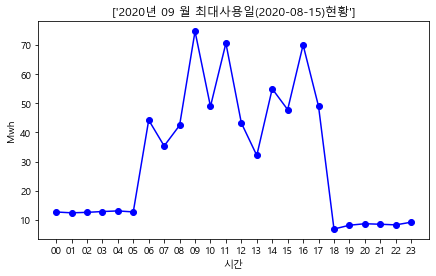

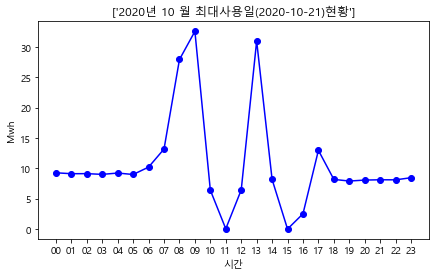

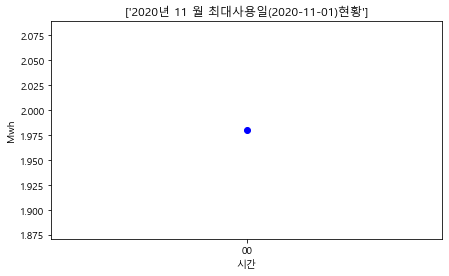

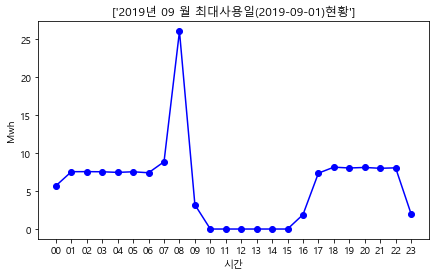

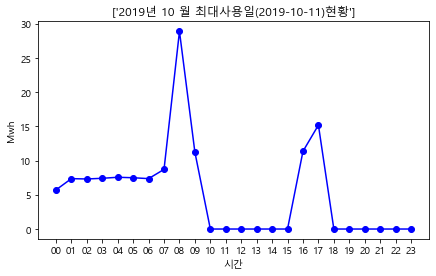

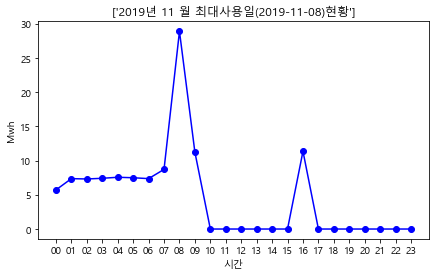

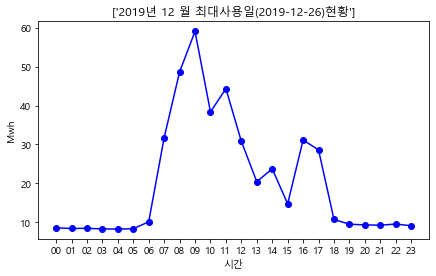

In [412]:
title_1 = '제 1장 일반 현황 분석'
title_1_1 = '1. {} 개년 통합 분석'.format(year_range)
title_1_2 = '2. 데이터 통계분석'
title_1_2_1 = ' 2.1 히스토그램'
title_1_2_2 = ' 2.2 박스플롯'
title_1_2_3 = '2.3 {}개년 월별 통합 분석'.format(year_range)
title_1_2_4 = '2.4 {}최대 전력 사용량 분석'.format(year_range)
title_1_3 = '3. {}년전 월별 통합 분석'.format(year_range-1)
title_1_3_1 = '3.1 {}년 Usage 기반 월별 분석'.format(year_range)
titie_1_4_1 = '동절기/하절기 데이터 분석'

title_2 = '제 2장 용도별 전력 분석'
document = Document()
document.add_heading(title_1,0)
document.add_heading(title_1_1,1)
document.add_paragraph('- 년간 전력 사용그래프')
document.add_picture('./images/total_year_usage.png')
document.add_paragraph('- 년간 전력 사용표')
table_1 = document.add_table(rows = year_range+2, cols = 3)
table_1.style = document.styles['Table Grid']
table_1.cell(0,0).merge(table_1.cell(1,0))
table_1.cell(0,1).merge(table_1.cell(0,2))
table_1.cell(0,0).text = '구분'
table_1.cell(0,1).text = '전력사용량'
table_1.cell(1,1).text = '사용량[toe]'
table_1.cell(1,2).text = '사용금액[백만원]'

for i in range(ismart.year.unique().size):
    year = ismart.year.unique()[i]
    usage = ismart[ismart.year==year].usage.sum()
    table_1.cell(i+2,0).text = '{}년'.format(year)
    table_1.cell(i+2,1).text = format(round(usage,2),',')


document.add_heading(title_1_2,1)
document.add_heading(title_1_2_1,1)
document.add_picture('./images/year_hist_usage.png')
document.add_heading(title_1_2_2,1)
document.add_picture('./images/year_boxplot_usage.png') 
document.add_heading(title_1_2_3,1)
document.add_paragraph('- 월별 전력 사용그래프')
document.add_picture('./images/year_total_usage.png')
document.add_paragraph('- 월별 전력 사용표')
table_2 = document.add_table(rows = year_range+2, cols = 14)
table_2.style = document.styles['Table Grid']
table_2.cell(0,0).text = '구분'
table_2.cell(0,1).text = '1월'
table_2.cell(0,2).text = '2월'
table_2.cell(0,3).text = '3월'
table_2.cell(0,4).text = '4월'
table_2.cell(0,5).text = '5월'
table_2.cell(0,6).text = '6월'
table_2.cell(0,7).text = '7월'
table_2.cell(0,8).text = '8월'
table_2.cell(0,9).text = '9월'
table_2.cell(0,10).text = '10월'
table_2.cell(0,11).text = '11월'
table_2.cell(0,12).text = '12월'
table_2.cell(0,13).text = '합계'
table_2.cell(ismart.year.unique().size+1,0).text = '합계'

for i in range(13):
    for j in range(len(year_monthly_usage.index)):
                   table_2.cell(j+1,i+1).text = \
            str(round(float(year_monthly_usage.iloc[year_monthly_usage.index==year_monthly_usage.index[j],i]),2))

for i in range(len(year_monthly_usage)):
    table_2.cell(i+1,0).text = year_monthly_usage.index[i]

for i in range(13):
    table_2.cell(ismart.year.unique().size+1,i+1).text = format(round(colsum[i],2),',')
    
document.add_heading(title_1_2_4,1)
table_3 = document.add_table(rows = year_range+2, cols = 14)
table_3.style = document.styles['Table Grid']
table_3.cell(0,0).text = '구분'
table_3.cell(0,1).text = '1월'
table_3.cell(0,2).text = '2월'
table_3.cell(0,3).text = '3월'
table_3.cell(0,4).text = '4월'
table_3.cell(0,5).text = '5월'
table_3.cell(0,6).text = '6월'
table_3.cell(0,7).text = '7월'
table_3.cell(0,8).text = '8월'
table_3.cell(0,9).text = '9월'
table_3.cell(0,10).text = '10월'
table_3.cell(0,11).text = '11월'
table_3.cell(0,12).text = '12월'
table_3.cell(0,13).text = '합계'
table_3.cell(ismart.year.unique().size+1,0).text = '합계'

for i in range(13):
    for j in range(len(year_monthly_usage.index)):
                   table_3.cell(j+1,i+1).text = \
            str(round(float(year_monthly_maxdemand.iloc[year_monthly_maxdemand.index==year_monthly_maxdemand.index[j],i]),2))

for i in range(len(year_monthly_usage)):
    table_3.cell(i+1,0).text = year_monthly_usage.index[i]

for i in range(13):
    table_3.cell(ismart.year.unique().size+1,i+1).text = format(round(colsum_maxdemand[i],2),',')
    
#document.add_paragraph('최대전력 사용량 peak치가 가장 큰 달은 {0}월이며 사용량은 {1}  입니다.'.format('07',peak_value))

document.add_heading(title_1_3,1)



i = 0
while i < year_range:
    title1 = '3.1 {}년 Usage기반 월별분석'.format(years[i])
    title2 = '  2){}년 월별 생산량 및 전기 사용 현황'.format(years[i])
    document.add_heading(title1)
    document.add_paragraph(title2)
   
    make_elec(years[i],"usage")
    document.add_picture("./images/year_hist_usage.png")
    table = document.add_table(rows = 2, cols = 14)
    table.style = document.styles['Table Grid']
    table.cell(0,0).text = str(years[i])
    table.cell(0,1).text = '1월'
    table.cell(0,2).text = '2월'
    table.cell(0,3).text = '3월'
    table.cell(0,4).text = '4월'
    table.cell(0,5).text = '5월'
    table.cell(0,6).text = '6월'
    table.cell(0,7).text = '7월'
    table.cell(0,8).text = '8월'
    table.cell(0,9).text = '9월'
    table.cell(0,10).text = '10월'
    table.cell(0,11).text = '11월'
    table.cell(0,12).text = '12월'
    table.cell(0,13).text = '합계'
    table.cell(1,0).text = '전력사용량\n[MWh]'

    monthly_use = year_monthly_usage[year_monthly_usage.index == years[i]]
    for cell in range(13):
        table.cell(1,cell+1).text = str(round(monthly_use.iloc[0,cell],2))
    
      
    document.add_heading('{}년 demand_max기반 월별분석'.format(years[i]),1)
    document.add_paragraph('2){}년 월별 생산량 및 전기 사용 현황'.format(years[i]))
   
    make_elec(years[i],"max_usage")
    document.add_picture("./images/year_hist_usage.png")
    
    monthly_maxuse = year_monthly_maxdemand[year_monthly_maxdemand.index==years[i]]
    
    table1 = document.add_table(rows = 2, cols = 14)
    table1.style = document.styles['Table Grid']
    table1.cell(0,0).text = str(years[i])
    table1.cell(0,1).text = '1월'
    table1.cell(0,2).text = '2월'
    table1.cell(0,3).text = '3월'
    table1.cell(0,4).text = '4월'
    table1.cell(0,5).text = '5월'
    table1.cell(0,6).text = '6월'
    table1.cell(0,7).text = '7월'
    table1.cell(0,8).text = '8월'
    table1.cell(0,9).text = '9월'
    table1.cell(0,10).text = '10월'
    table1.cell(0,11).text = '11월'
    table1.cell(0,12).text = '12월'
    table1.cell(0,13).text = '합계'
    table1.cell(1,0).text = '전력사용량\n[MWh]'

    
    for cell in range(13):
        table1.cell(1,cell+1).text = str(round(monthly_maxuse.iloc[0,cell],2))
    
    i = i + 1


document.add_heading(titie_1_4_1,1)
document.add_heading('동절기/하절기 요일별 전력사용량 분석')
i = 0
while i < year_range:
    year = years[i]
    season_usage_graph(str(year))
    i = i+1

document.add_heading('동절기/하절기 요일별 최대수요분석')
i = 0
while i < year_range:
    year = years[i]
    season_max_graph(str(year))
    i = i+1

document.add_heading('5. {}개년 최대 사용월의 일별 데이터 분석'.format(year_range),1)
i = 0
while i < year_range:
    year = years[i]
    day_usage_graph(str(year))
    i= i+1

i = 0
while i < year_range:
    year = years[i]
    day_max_usage_graph(str(year))
    i= i+1




document.save('{}.docx'.format(str(year_max)))